## Data mapping
Since we have 3 files in total, so we have to combine it and split the data into train/test.

In [ ]:
#Import package and read files
import pandas as pd
import json
import os

os.chdir(r'C:\Users\Kenny\Desktop\DM\Kaggle2')

data_identification = pd.read_csv('data_identification.csv')
emotion = pd.read_csv('emotion.csv')

In [ ]:
# 讀取JSON檔案，並使用json_normalize展平嵌套字段
df = pd.read_json('tweets_DM.json', lines=True)
df_flat = pd.json_normalize(df['_source'])

# 將展平的數據添加回原始DataFrame
df[['hashtags', 'tweet_id', 'text']] = df_flat[['tweet.hashtags', 'tweet.tweet_id', 'tweet.text']]

# 刪除原始的不需要的列
df = df.drop('_source', axis=1)
df = df.drop(['_index','_type'], axis=1)


In [ ]:
#Mapping the data by tweet_id
df_merge_1 = pd.merge(df, data_identification, on='tweet_id', how='outer')
df_all = pd.merge(df_merge_1, emotion, on='tweet_id', how='outer')

In [ ]:
#Output the data so that don't need to mapping the data again.
df_all[df_all['identification']=='train'].to_csv('train.csv',index=False)
df_all[df_all['identification']=='test'].to_csv('test.csv',index=False)


## Read the file

In [15]:
import pandas as pd
import os 

os.chdir(r'C:\Users\Kenny\Desktop\DM\Kaggle2')


In [20]:
#Read the files and drop unneeded columns
train = pd.read_csv('train.csv')
train = train.drop(['_crawldate', 'tweet_id', 'identification'], axis=1)
X = train.drop('emotion', axis=1)
X = X.rename(columns = {'_score':'score'})
Y = train['emotion']

x_test = pd.read_csv('test.csv')
x_test = x_test.drop(['_crawldate', 'tweet_id', 'identification', 'emotion'], axis=1)
x_test = x_test.rename(columns = {'_score':'score'})

#Split the data into train/validation set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)


## Modeling

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# build analyzers (bag-of-words)
TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
TFIDF_1000.fit(X_train['text'])

feature_names_1000 = TFIDF_1000.get_feature_names_out()


# for a classificaiton problem, you need to provide both training & testing data
X_train = TFIDF_1000.transform(X_train['text'])
X_val = TFIDF_1000.transform(X_val['text'])
X_test = TFIDF_1000.transform(x_test['text'])

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_val.shape: ', X_val.shape)
print('Y_val.shape: ', Y_val.shape)
print('X_test.shape: ', X_test.shape)


C:\Users\Kenny\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train.shape:  (1164450, 10000)
Y_train.shape:  (1164450,)
X_val.shape:  (291113, 10000)
Y_val.shape:  (291113,)
X_test.shape:  (411972, 10000)


In [22]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

#Using the labelencoder to transform the emotion label into number, so can input the data into the model.
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)


In [23]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Using Optuna for hyperparameter tuning
def objective(trial):
    #Set the hyperparameter range
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    #Build the XGBoost model
    model = XGBClassifier(**params, random_state=42)

    #Train the model
    model.fit(X_train, Y_train_encoded)

    #Predict on the validation set
    Y_val_pred = model.predict(X_val)
    
    #Using mean F1 score as optimizing target
    f1 = f1_score(Y_val_encoded, Y_val_pred, average='macro')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
#Using the best hyperparameter set to construct the model
best_params = study.best_params
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, Y_train_encoded)

# Predict on the test set
y_test_pred = final_model.predict(X_test)


[I 2023-12-27 03:46:12,312] A new study created in memory with name: no-name-c76134c8-79f9-40e5-b50f-481efbea82b5
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2023-12-27 05:32:49,026] Trial 3 finished with value: 0.45750861816358745 and parameters: {'max_depth': 9, 'learning_rate': 0.19786554957127267, 'n_estimators': 243, 'subsample': 0.7475359942234887, 'colsample_bytree': 0.9850804129106225, 'gamma': 0.000741546997009694, 'reg_alpha': 2.6311029525120927e-08, 'reg_lambda': 5.492123875100839e-07}. Best is trial 3 with value: 0.45750861816358745.
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

[I 2023-12-27 06:21:37,023] Trial 7 finished with value: 0.37492519809432057 and parameters: {'max_depth': 5, 'learning_rate': 0.039624092992890166, 'n_estimators': 257, 'subsample': 0.6378247366026331, 'colsample_bytree': 0.6496168769795065, 'gamma': 1.5491268721661737e-06, 'reg_alpha': 1.1533291787404346e-07, 'reg_lambda': 6.1123922542406855e-06}. Best is trial 3 with value: 0.45750861816358745.
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[W 2023-12-27 07:51:09,499] Trial 11 failed with parameters: {'max_depth': 10, 'learning_rate': 0.1998561349898464, 'n_estimators': 227, 'subsample': 0.9992378365573094, 'colsample_bytree': 0.9642137962426929, 'gamma': 0.0011098240816973495, 'reg_alpha': 0.00014963086151114735, 'reg_lambda': 3.304230571646778e-08} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Kenny\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Kenny\AppData\Local\Temp\ipykernel_23104\2963689113.py", line 22, in objective
    model.fit(X_train, Y_train_encoded)
  File "C:\Users\Kenny\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Kenny\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  F

KeyboardInterrupt: 

In [ ]:
'''I also used LightGBM for modeling, but the result was not good enough :('''
# import optuna
# from lightgbm import LGBMClassifier
# from sklearn.metrics import f1_score

# def objective(trial):
#     params = {
#     'max_depth': trial.suggest_int('max_depth', 3, 10),
#     'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
#     'n_estimators': trial.suggest_int('n_estimators', 50, 200),
#     'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#     'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#     'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#     'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
# }

#     # Build the LightGBM model
#     model = LGBMClassifier(**params, random_state=42)

#     # Train the model
#     model.fit(X_train, Y_train_encoded)

#     # Predict on the validation set
#     Y_val_pred = model.predict(X_val)

#     f1 = f1_score(Y_val_encoded, Y_val_pred, average='macro')
#     return f1

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)
# best_params = study.best_params
# final_model = LGBMClassifier(**best_params, random_state=42)
# final_model.fit(X_train, Y_train_encoded)

# # Predict on the test set
# y_test_pred = final_model.predict(X_test)


I also used Word2vec, BERT, Transformer for modeling. In Word2vec, the result was not so good; In 
the other 2 models, since I was using CPU for modeling, the training time for each epoch is around
200 hours, which is impossible to finish the training process.
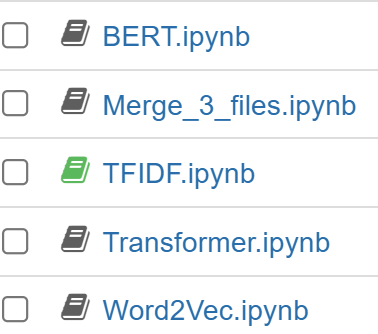

In [ ]:
#Return the prediction result (0-7) into emotion labels(anger, anticipation, ...)
y_test_decoded = label_encoder.inverse_transform(y_test_pred)


In [ ]:
#Output the subimssion file
tweet_id = pd.read_csv('test.csv')
tweet_id = tweet_id['tweet_id']
y_test_decoded = pd.DataFrame(y_test_decoded)
submission = pd.concat([tweet_id, y_test_decoded], axis=1)
submission = submission.rename(columns={'tweet_id':'id', 0:'emotion'})
submission.to_csv('submission1.csv', index=False)
